## Load Libraries

In [2]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

'2.0.0-beta1'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [3]:
DATA_DIR = 'data'
IMAGE_WIDTH = 120
IMAGE_HEIGHT = 120
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data


In [4]:
import pathlib
data_root = pathlib.Path(DATA_DIR)
print(data_root)

data


In [5]:
for item in data_root.iterdir():
  print(item)

data/.DS_Store
data/test
data/data.zip
data/train
data/validation


### Image Preprocessing

In [6]:
train_dir = DATA_DIR + '/train'
validation_dir = DATA_DIR + '/validation'

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_validation = len(os.listdir(validation_cats_dir))
num_dogs_validation = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_validation = num_cats_validation + num_dogs_validation

print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_validation)
print('total validation dog images:', num_dogs_validation)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)
print("--")

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1)

train_generator = train_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              class_mode='binary')

total training cat images: 10001
total training dog images: 10001
total validation cat images: 2500
total validation dog images: 2500
--
Total training images: 20002
Total validation images: 5000
--
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Explore some training images

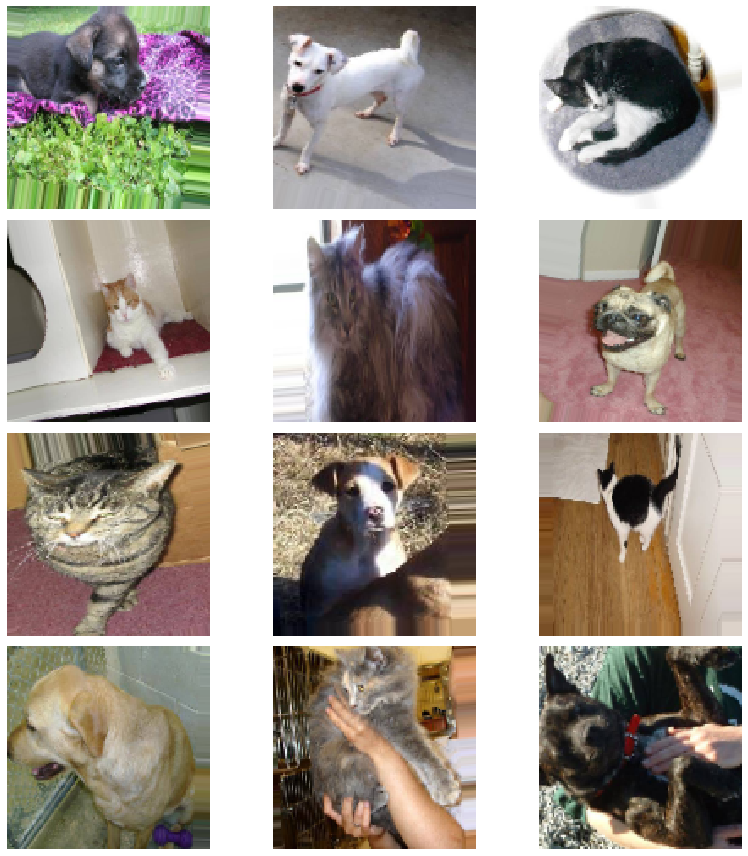

In [7]:
sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
  
plotImages(sample_training_images[:12])

### Plot augmented images

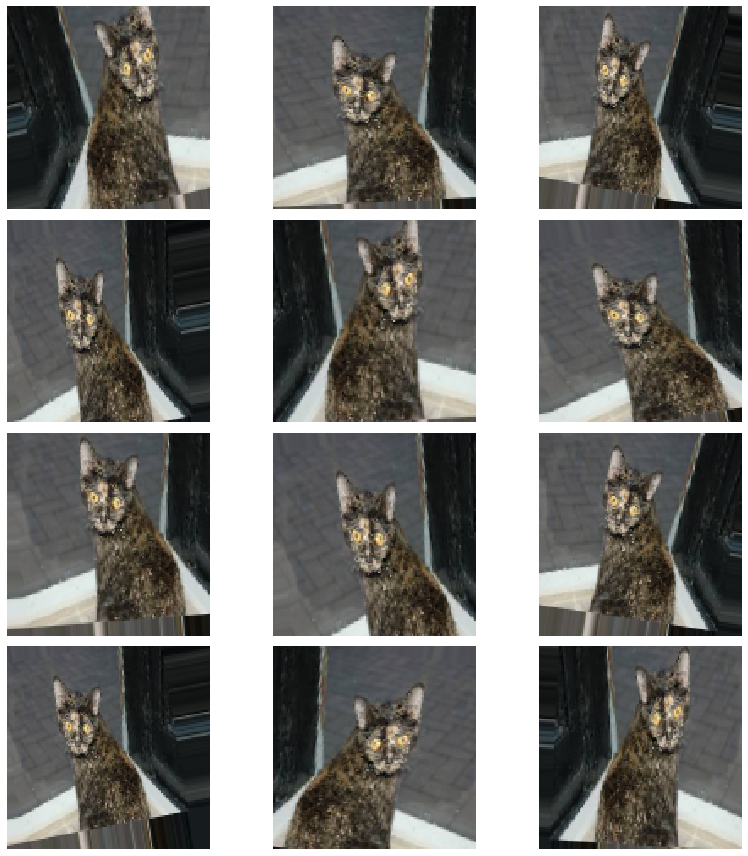

In [8]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

## Create & Train Model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def create_model():
  model = tf.keras.Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 118, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0

### Create Checkpoint

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

### Train model

In [14]:
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

Epoch 1/20


W0824 21:52:57.827116 4566193600 deprecation.py:323] From /Users/jodythai/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  7/625 [..............................] - ETA: 15:32 - loss: 1.5061 - accuracy: 0.5670

Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-5:
Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jodythai/anaconda3/lib/python3.7/multiprocessin

KeyboardInterrupt: 

## Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save model

In [ ]:
# Save the entire model to a HDF5 file
model.save('static/models/my_model.h5')

## Transfer learning

In [ ]:
# Preprocess Train dataset
train_img_datagen_tl = ImageDataGenerator(
                                            rescale=1./255,
                                            
                                         )

train_generator_tl = train_img_datagen_tl.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

### Create base model
We will create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.
By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (IMAGE_WIDTH, IMAGE_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting `layer.trainable = False`), we prevent the weights in these layers from being updated during training.

In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
# model_tl = transfer learning model
model_tl = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tl.summary()

In [ ]:
# Observe trainable variables inherited from the base model
len(model.trainable_variables)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_tl = [
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model_tl.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
# optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
epochs = 20

history_tl = model_tl.fit_generator(
                                    train_generator_tl,
                                    steps_per_epoch=total_train // BATCH_SIZE,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps=total_validation // BATCH_SIZE,
                                    workers=5,
                                    use_multiprocessing=True,
                                    callbacks=callbacks_tl
                                   )

In [ ]:
acc_tl = history_tl.history['accuracy']
val_acc_tl = history_tl.history['val_accuracy']

loss_tl = history_tl.history['loss']
val_loss_tl = history_tl.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model_tl.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model_tl.summary()

In [ ]:
len(model_tl.trainable_variables)

In [ ]:
callbacks_tl_fine = [
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model_tl_fine.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
epochs = 20

history_tl_fine = model_tl.fit_generator(train_generator_tl, 
                                      steps_per_epoch=total_train // BATCH_SIZE,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=total_validation // BATCH_SIZE,
                                      workers=5,
                                      use_multiprocessing=True,
                                      callbacks=callbacks_tl_fine
                                     )

In [ ]:
acc_tl += history_tl_fine.history['accuracy']
val_acc_tl += history_tl_fine.history['val_accuracy']

loss_tl += history_tl_fine.history['loss']
val_loss_tl += history_tl_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save Model

In [ ]:
# Save the entire model to a HDF5 file
model_tl.save('static/models/my_model_tl.h5')